# Interpretability

In [1]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

import sys
sys.path.append('../../../')

import numpy as np
import pandas as pd

from molgraph.chemistry import MolecularGraphEncoder
from molgraph.chemistry import AtomFeaturizer, BondFeaturizer 
from molgraph.chemistry import features

from molgraph.models import GradientActivationMapping
from molgraph.models import IntegratedSaliencyMapping

### Construct a `MolecularGraphEncoder`

In [2]:
atom_encoder = AtomFeaturizer([
    features.Symbol({'C', 'N', 'O'}, oov_size=1),
    features.Hybridization({'SP', 'SP2', 'SP3'}, oov_size=1),
    features.HydrogenDonor(),
    features.HydrogenAcceptor(),
    features.Hetero()
])

bond_encoder = BondFeaturizer([
    features.BondType({'SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC'}),
    features.Rotatable()
])

mol_encoder = MolecularGraphEncoder(atom_encoder, bond_encoder, positional_encoding_dim=None)
mol_encoder

MolecularGraphEncoder(atom_encoder=AtomFeaturizer(features=[Symbol(allowable_set={'O', 'N', 'C'}, ordinal=False, oov_size=1), Hybridization(allowable_set={'SP2', 'SP3', 'SP'}, ordinal=False, oov_size=1), HydrogenDonor(), HydrogenAcceptor(), Hetero()], dtype='float32', ndim=11), bond_encoder=BondFeaturizer(features=[BondType(allowable_set={'TRIPLE', 'DOUBLE', 'AROMATIC', 'SINGLE'}, ordinal=False, oov_size=0), Rotatable()], dtype='float32', ndim=5), positional_encoding_dim=None, self_loops=False)

### Obtain dataset as `pd.DataFrame`

In [3]:
path = tf.keras.utils.get_file(
    fname='ESOL.csv',
    origin='http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/ESOL.csv',
)
df = pd.read_csv(path)
df.head(3)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)


### Obtain SMILES ("x"; string representation of molecules) and associated labels ("y")

In [4]:
x, y = df['smiles'].values, df['measured log solubility in mols per litre'].values

In [5]:
x_data = mol_encoder(x)

print(x_data, end='\n\n')
print('node_feature shape:', x_data.node_feature.shape)
print('edge_dst shape:    ', x_data.edge_dst.shape)
print('edge_src shape:    ', x_data.edge_src.shape)
print('edge_feature shape:', x_data.edge_feature.shape)

GraphTensor(node_feature=<tf.RaggedTensor: shape=(1128, None, 11), dtype=float32, ragged_rank=1, row_splits_dtype=int32>, edge_feature=<tf.RaggedTensor: shape=(1128, None, 5), dtype=float32, ragged_rank=1, row_splits_dtype=int32>, edge_dst=<tf.RaggedTensor: shape=(1128, None), dtype=int32, ragged_rank=1, row_splits_dtype=int32>, edge_src=<tf.RaggedTensor: shape=(1128, None), dtype=int32, ragged_rank=1, row_splits_dtype=int32>)

node_feature shape: (1128, None, 11)
edge_dst shape:     (1128, None)
edge_src shape:     (1128, None)
edge_feature shape: (1128, None, 5)


### Model

In [6]:
from molgraph.layers import GCNConv, Readout

sequential_model = tf.keras.Sequential([
    tf.keras.layers.Input(type_spec=x_data.unspecific_spec),
    GCNConv(128, name='conv_1'),
    GCNConv(128, name='conv_2'),
    GCNConv(128, name='conv_3'),
    GCNConv(128, name='conv_4'),
    Readout(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1)
])

sequential_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (GCNConv)            (None, None, 128)         4864      
                                                                 
 conv_2 (GCNConv)            (None, None, 128)         33408     
                                                                 
 conv_3 (GCNConv)            (None, None, 128)         33408     
                                                                 
 conv_4 (GCNConv)            (None, None, 128)         33408     
                                                                 
 segment_pooling_readout (Se  (None, 128)              0         
 gmentPoolingReadout)                                            
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                        

In [7]:
sequential_model.compile('adam', 'mse', ['mae'])
sequential_model.fit(x_data, y, epochs=50, verbose=2)

Epoch 1/50
36/36 - 3s - loss: 4.5034 - mae: 1.6147 - 3s/epoch - 88ms/step
Epoch 2/50
36/36 - 0s - loss: 2.7084 - mae: 1.3192 - 218ms/epoch - 6ms/step
Epoch 3/50
36/36 - 0s - loss: 2.7685 - mae: 1.3170 - 224ms/epoch - 6ms/step
Epoch 4/50
36/36 - 0s - loss: 2.5584 - mae: 1.2529 - 218ms/epoch - 6ms/step
Epoch 5/50
36/36 - 0s - loss: 2.2715 - mae: 1.1871 - 212ms/epoch - 6ms/step
Epoch 6/50
36/36 - 0s - loss: 2.0555 - mae: 1.1137 - 216ms/epoch - 6ms/step
Epoch 7/50
36/36 - 0s - loss: 2.1714 - mae: 1.1597 - 217ms/epoch - 6ms/step
Epoch 8/50
36/36 - 0s - loss: 1.9391 - mae: 1.0674 - 213ms/epoch - 6ms/step
Epoch 9/50
36/36 - 0s - loss: 1.8799 - mae: 1.0439 - 213ms/epoch - 6ms/step
Epoch 10/50
36/36 - 0s - loss: 1.8774 - mae: 1.0468 - 224ms/epoch - 6ms/step
Epoch 11/50
36/36 - 0s - loss: 1.9123 - mae: 1.0716 - 219ms/epoch - 6ms/step
Epoch 12/50
36/36 - 0s - loss: 1.9088 - mae: 1.0670 - 217ms/epoch - 6ms/step
Epoch 13/50
36/36 - 0s - loss: 1.8310 - mae: 1.0372 - 216ms/epoch - 6ms/step
Epoch 14/5

In [8]:
gam_model = GradientActivationMapping(
    sequential_model, 
    ['conv_1', 'conv_2', 'conv_3', 'conv_4'], 
    'linear',
    discard_negative_values=False,
)    

gam = gam_model.predict(x_data, verbose=1)
print(gam[0])

36/36 [==============================] - 1s 5ms/step
tf.Tensor(
[ 7.6008728e-04  1.8574279e-03  9.4965595e-04 -1.4838621e-03
  1.9675791e-03 -1.2541342e-03  1.0174317e-03  4.0349006e-04
 -1.4971232e-03  1.8268001e-03 -2.0075205e-03 -1.9944266e-03
 -1.8114154e-04 -2.5734599e-04 -1.7582015e-03 -5.9142063e-04
 -1.5453123e-03 -1.8650061e-03 -1.5453123e-03 -5.9142063e-04
  7.9807895e-04 -4.2576139e-05  7.9243176e-04 -4.7727313e-05
  7.1756763e-04 -2.1381071e-05  7.9776591e-04 -4.2787724e-05
  7.9221197e-04 -4.7727313e-05  7.0365745e-04 -2.1054788e-05], shape=(32,), dtype=float32)


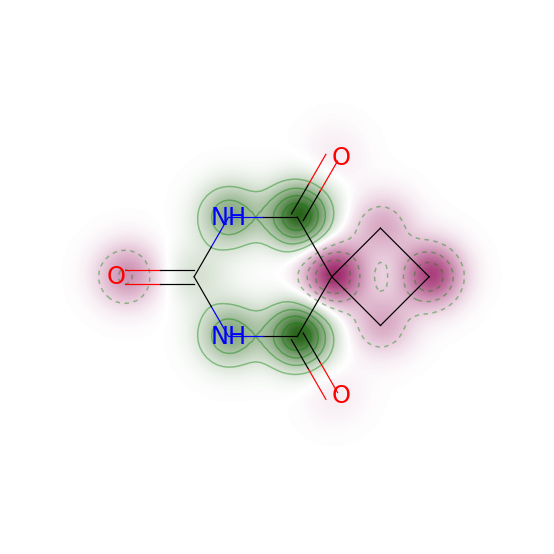

In [9]:
from molgraph.chemistry.vis_utils import visualize_maps

visualize_maps(x[42], gam[42])